upload the dataset inside the drive/data => **drive/data/dataset**

In [1]:
# imports all necessary libraries 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# base address of dataset
base = "/content/drive/MyDrive/data/dataset/"

In [3]:
# Saved Models load this or re-run the next section to train the model from the start
linear_regressor2 = pickle.load(open('/content/drive/MyDrive/models/linear_regressor2.pkl', 'rb'))
linear_regressor1 = pickle.load(open('/content/drive/MyDrive/models/linear_regressor1.pkl', 'rb'))
linear_regressor_avg = pickle.load(open('/content/drive/MyDrive/models/linear_regressor_avg.pkl', 'rb'))

In [12]:
# read all dirty images
dirty_images_paths = [base + "train/" + str(x) + ".png" for x in range(1, 216)]
dirty_images = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in dirty_images_paths]
dirty_images = [i for i in dirty_images if i is not None]

# read all clean images
clean_images_paths = [base + "train_cleaned/" + str(x) + ".png" for x in range(1, 216)]
clean_images = [cv2.imread(x, cv2.IMREAD_GRAYSCALE) for x in clean_images_paths]
clean_images = [i for i in clean_images if i is not None]

# train regression model
window_size = 20

def get_linear_regressor(index):
  linear_regressor = LinearRegression()
  # 4, 5 | 1, 2 |
  clean = clean_images[index]
  dirty = dirty_images[index]

  # Create a padded version of the image.
  pad_width = [(window_size // 2, window_size // 2), (window_size // 2, window_size // 2)]
  padded_image = np.pad(dirty, pad_width, mode='constant', constant_values=0.0)

  print(padded_image)
  # Create a matrix of features for linear regression.
  X = np.zeros((dirty.shape[0] * dirty.shape[1], window_size ** 2))
  for i in range(dirty.shape[0]):
      for j in range(dirty.shape[1]):
          idx = i * dirty.shape[1] + j
          x = padded_image[i:i+window_size, j:j+window_size].flatten()
          X[idx] = x

  # Fit a linear regression model to the features.
  y = clean.flatten()
  linear_regressor.fit(X, y)
  return linear_regressor

linear_regressor1 = get_linear_regressor(4)
linear_regressor2 = get_linear_regressor(1)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
# function to get denoised image
def denoise(dirty_image):
  window_size = 20
  # Create a padded version of the image.
  pad_width = [(window_size // 2, window_size // 2), (window_size // 2, window_size // 2)]
  padded_image = np.pad(dirty_image, pad_width, mode='constant', constant_values=0.0)

  denoised_image = np.zeros_like(dirty_image)
  for i in range(dirty_image.shape[0]):
      for j in range(dirty_image.shape[1]):
          x = padded_image[i:i+window_size, j:j+window_size].flatten()
          y_pred = linear_regressor2.predict(x.reshape(1, -1))[0]
          denoised_image[i, j] = 255 if y_pred > 255 else (0 if y_pred < 0 else y_pred)

  # Create a padded version of the image.
  pad_width = [(window_size // 2, window_size // 2), (window_size // 2, window_size // 2)]
  padded_image = np.pad(denoised_image, pad_width, mode='constant', constant_values=0.0)

  for i in range(dirty_image.shape[0]):
      for j in range(dirty_image.shape[1]):
          x = padded_image[i:i+window_size, j:j+window_size].flatten()
          y_pred = linear_regressor1.predict(x.reshape(1, -1))[0]
          denoised_image[i, j] = 255 if y_pred > 255 else (0 if y_pred < 0 else y_pred)
          
  return np.reshape(denoised_image, (dirty_image.shape[0], dirty_image.shape[1]))

In [5]:
# function to get denoised image from avg linear regression model
def denoise_avg(dirty_image):
  dirty = np.reshape(dirty_image.flatten(), (dirty_image.shape[0]*dirty_image.shape[1] ,1))
  denoised_image = np.zeros_like(dirty)
  for i in range(dirty.shape[0]):
      for j in range(dirty.shape[1]):
          x = dirty[i:i+1, j:j+1].flatten()
          y_pred = linear_regressor_avg.predict(x.reshape(1, -1))[0]
          denoised_image[i, j] = 255 if y_pred > 255 else (0 if y_pred < 0 else y_pred)
  return np.reshape(denoised_image, (dirty_image.shape[0], dirty_image.shape[1]))

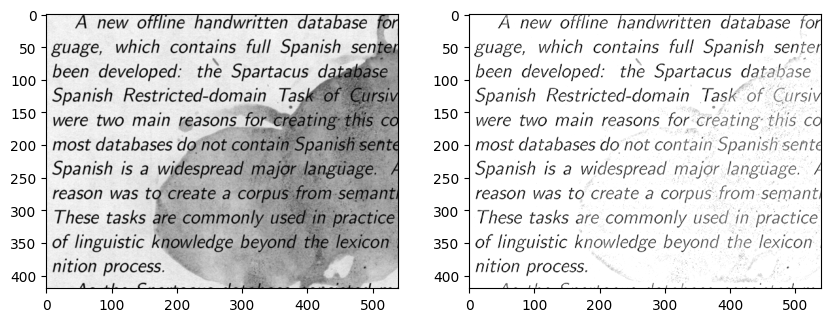

In [13]:
# calls denoising function and shows denoised images
dirty_images_paths = base + "test/97.png"
dirty = cv2.imread(dirty_images_paths, cv2.IMREAD_GRAYSCALE)
denoised_image = denoise(dirty)

#show denoised image
f, axarr = plt.subplots(1, 2, figsize=(10, 10))
axarr[0].imshow(dirty, cmap="gray")
axarr[1].imshow(denoised_image, cmap="gray")

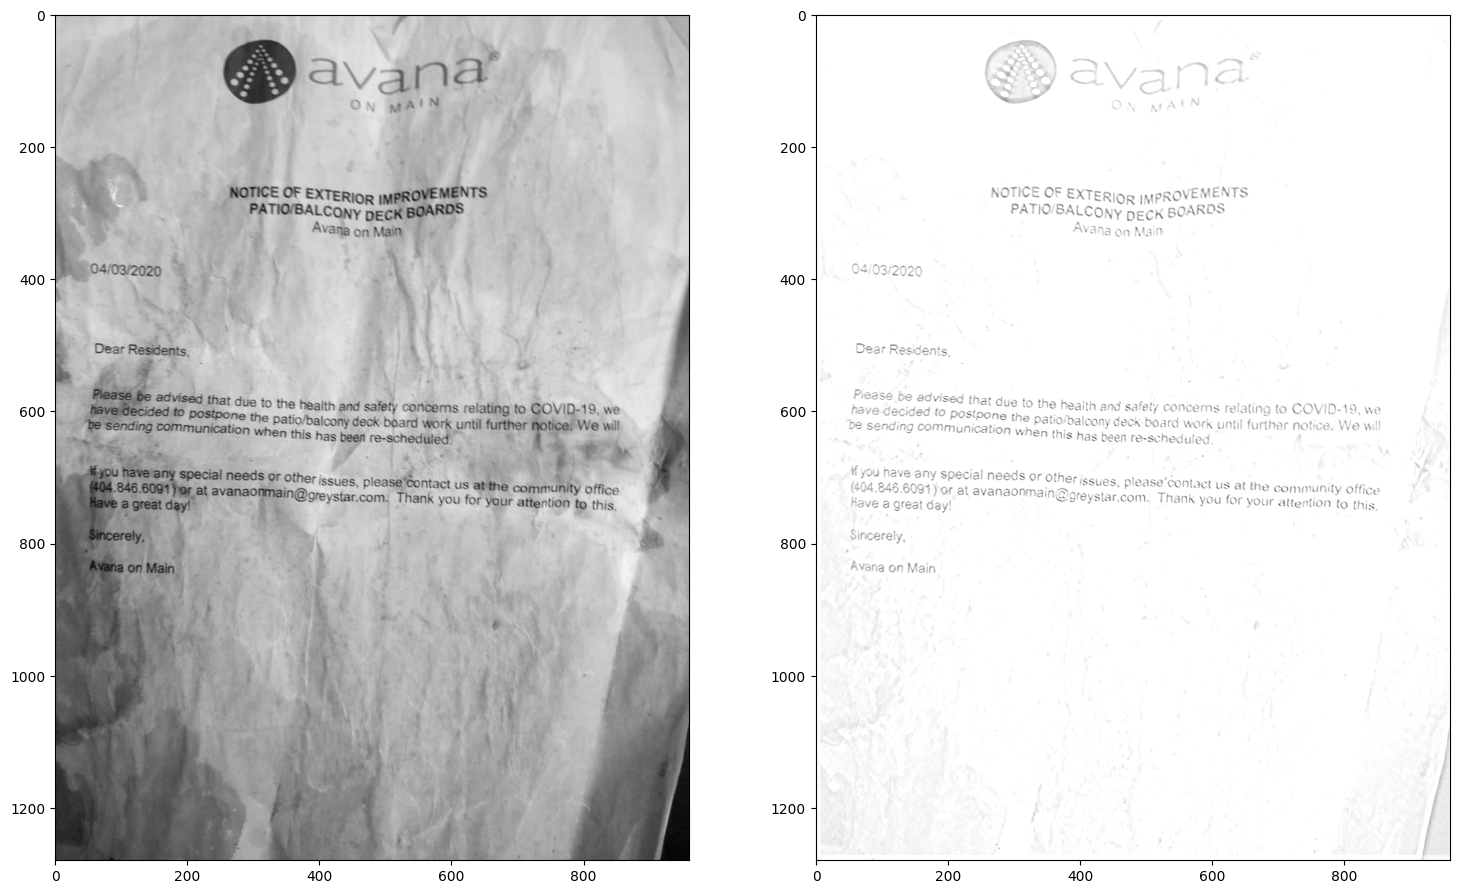

In [7]:
# denoising real documents
dirty_images_paths = base + "real_value.jpg"
dirty = cv2.imread(dirty_images_paths, cv2.IMREAD_GRAYSCALE)
_denoised_image = denoise(dirty)

#show denoised image
f, axarr = plt.subplots(1, 2, figsize=(18, 18))
axarr[0].imshow(dirty, cmap="gray")
axarr[1].imshow(_denoised_image, cmap="gray")

In [8]:
# install all libraries for quantitative metrics
!pip install sewar
from sewar.full_ref import uqi, psnr, rmse, ssim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10583 sha256=ef83d4315758e5d5c713d7ede6e317bb83313a5b773bbdb99d0da61b41baf606
  Stored in directory: /root/.cache/pip/wheels/06/71/a0/ce363fc3bc7374b69963c517c1f570358f46e881cee13ae5b6
Successfully built sewar


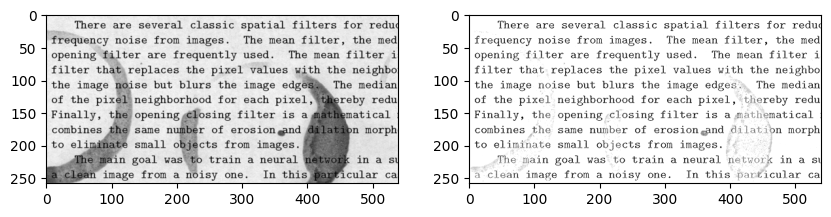

In [10]:
# calls denoising function and shows denoised images
dirty_images_paths = base + "train/63.png"
clean_images_paths = base + "train_cleaned/63.png"
dirty = cv2.imread(dirty_images_paths, cv2.IMREAD_GRAYSCALE)
clean = cv2.imread(dirty_images_paths, cv2.IMREAD_GRAYSCALE)
denoised_image = denoise(dirty)

#show denoised image
f, axarr = plt.subplots(1, 2, figsize=(10, 10))
axarr[0].imshow(dirty, cmap="gray")
axarr[1].imshow(denoised_image, cmap="gray")

In [11]:
# prints all quantitative metrics 

print("RMSE: ", rmse(clean, denoised_image)) #RMSE
print("UQI: ", uqi(clean, denoised_image)) #UQI
print("PSNR: ", psnr(clean, denoised_image)) #PSNR

RMSE:  57.672470183890034
UQI:  0.9236423274912289
PSNR:  12.911432544998007
